In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

import pickle
from pcygni_profile import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    plt.rcParams['pcolor.shading'] = 'nearest'
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

def lum_dist(p, psig, beta, dbeta, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    theta = 2*np.sqrt(p[1]*10**(7)/np.pi)
    dtheta = 1/np.sqrt(p[1])*np.sqrt(10**(7)/np.pi)*psig[1]

    v = beta*c/2; dv = dbeta*c/2 #factor of 2
    t = (n_days-dt) * (3600*24)
    r = v*t; dr = dv*t 
    
    D = r/theta*2# factor of 2 
    dD = ( (r/theta**2*2*dtheta)**2 + (dr/theta*2)**2 )**(1/2)

    D_mpc = D*(3.2408e-23)
    dD_mpc = dD*(3.2408e-23)
    
    return D_mpc, dD_mpc

n_days = [1.427, 2.417, 3.413, 4.403]


In [2]:
OB = 'OB1'

In [69]:
path = '.\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[1])
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14360))) & (~((x[:,0] > 17550) & (x[:,0] < 19000))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (x[:,0] > 3500) & (x[:,0] < 22500)

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,3][exc_reg_2]

In [82]:
from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.07,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653, z_pec=0.): #blackbody
    wav = wav*(1+z_pec)
    a = 2.0*h*pi*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5)*(math.e**b - 1.0) )
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    #correction = p_cygni_line_corr(wav, v_out, v_phot, tau, lam, vref=vref, ve=ve, t0=t0)
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    #gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau1 = models.Gaussian1D.evaluate(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity#+gau2#+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2)
    
    if data is None:
        return model
    return (model - data)/error


#### Fit structure

In [20]:
p_i, cov_i = curve_fit(planck_with_mod, wl*10**(-10), flux, sigma = error,
                   p0 = p007)  #,
#                  p0 = [5200, 5*10**(-30)], absolute_sigma=True)

KeyboardInterrupt: 

In [44]:
## 0.07
#p007 = p_i
p_i, lum_dist([0,p_i[1]], [0,np.sqrt(cov_i[0,0])], 
         p_i[3],np.sqrt(cov_i[3,3]),  
         n_days=2.42) 

(array([3.62209459e+03, 1.23971337e-29, 2.99547790e-01, 2.56988437e-01,
        1.00754287e+02, 3.60428326e-01]),
 (41.58153104559517, inf))

In [ ]:
#p = lmfit.Parameters()
#OB = 'OB2'
#with open("./data/%s_init_no_gaussian.json"%OB, 'r') as infile:
#    p.load(infile)

start = time.time()
mi = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
end = time.time()
print('Time elapsed:',(end-start)/60)

In [ ]:
lum_dist([0,mi.params['N']], [0,np.sqrt(cov_i[0,0])], 
         mi.params['vphot'],np.sqrt(cov_i[3,3]),  
         n_days=2.42) 

In [79]:
lum_dist([0,mi.params['N']], [0,np.sqrt(cov_i[0,0])], 
         mi.params['vphot'],np.sqrt(cov_i[3,3]),  
         n_days=2.42) 

(43.189538527533976, inf)

In [72]:
p

name,value,initial value,min,max,vary
T,3623.00484,3618,2500.00000,7500.00000,True
N,1.2292e-29,1.23e-29,-inf,inf,True
vphot,0.26614309,0.257,0.00000000,1.00000000,True
vmax,0.30214893,0.3,0.00000000,1.00000000,True
t0,212400.000,212400,-inf,inf,False
tau,2.82982044,3,0.00000000,10.0000000,True
vref,0.63969663,0.0,0.00000000,1.00000000,True
ve,0.30000000,0.3,0.00000000,1.00000000,False
occult,0.55370986,2,0.10000000,10.0000000,True
amp1,0.01000000,0.01,0.01000000,5.00000000,False


In [54]:
#with open("./data/%s_bb_pc_occult.json"%OB, 'w') as outfile:
#    mi.params.dump(outfile)

In [74]:
p = lmfit.Parameters()
with open("./data/%s_bb_pc_occult.json"%OB, 'r') as infile:
    p.load(infile)
#p

In [76]:
#flux_fit = residual(p,wl*1e-10)
flux_fit = residual(mi.params,wl*1e-10)

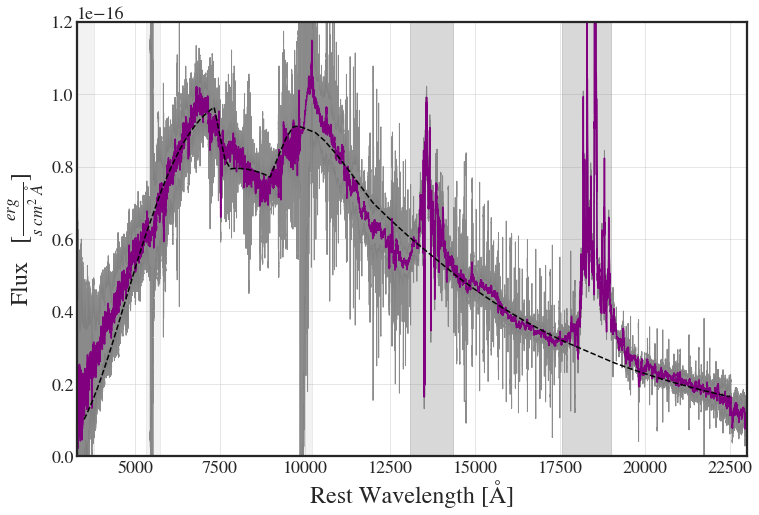

In [77]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(x[:,0], x[:,1], label='X-shooter spectra', color='purple')
#plt.plot(wl, flux, label='X-shooter spectra', color='orange', alpha=0.5)
#p, cov = curve_fit(planck, x[:,0][exc_reg]*10**(-10), x[:,1][exc_reg], sigma = x[:,3][exc_reg],
#                   p0 = [5200, 5*10**(-30)], absolute_sigma=True)
#psig = np.sqrt(np.diagonal(cov)) #*40

#print(p, psig)

plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
plt.fill_between(x[:,0], x[:,1]-x[:,3], x[:,1]+x[:,3], 
                 color='grey', alpha=0.9)
plt.ylim(0, 1.2e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14360], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 3800], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

#### Markow Chain Monto Carlo - Sample Space with emcee

In [57]:
def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""
    model = residual(pars, wl*1e-10)
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

mini = lmfit.Minimizer(lnprob, p)

start = time.time()
nwalkers = 14 #v = p.valuesdict()
res = mini.emcee(nwalkers=nwalkers, burn=100, steps=2000, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed:',(end-start)/60 )

 17%|█▋        | 348/2000 [1:47:02<8:44:05, 19.03s/it] C:\Users\asnep\Downloads\Kilonova\pcygni_profile.py:489: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, mode))[0]
100%|██████████| 2000/2000 [11:14:35<00:00, 20.24s/it]    


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [184.20476365 175.54698286 279.17805717 139.37938754 287.1360893
 244.06939589 290.46376102]
Time elapsed: 674.8534297188123


In [58]:
res

In [71]:
import pickle

#with open("./data/%emcee_no_gaussian_2dataset.json"%OB, 'w') as outfile:
#    res.params.dump(outfile)

#with open("./data/emcee_bb_pc_occult.pkl", 'wb') as outfile:
#    pickle.dump(res, outfile)

In [59]:
res.params['N'].value, res.params['N'].stderr, res.params['vphot'].value, res.params['vphot'].stderr

(5.268461569527102e-30,
 4.107676174126891e-32,
 0.29300115982494834,
 0.002286451815072893)

In [60]:
lum_dist([0,res.params['N'].value], [0,res.params['N'].stderr],
         res.params['vphot'].value, res.params['vphot'].stderr, 
         n_days=1.43)

(42.972996376300244, 0.37485848377469166)

### Plotting

In [61]:
flux_fit = residual(res.params,wl*10**(-10))

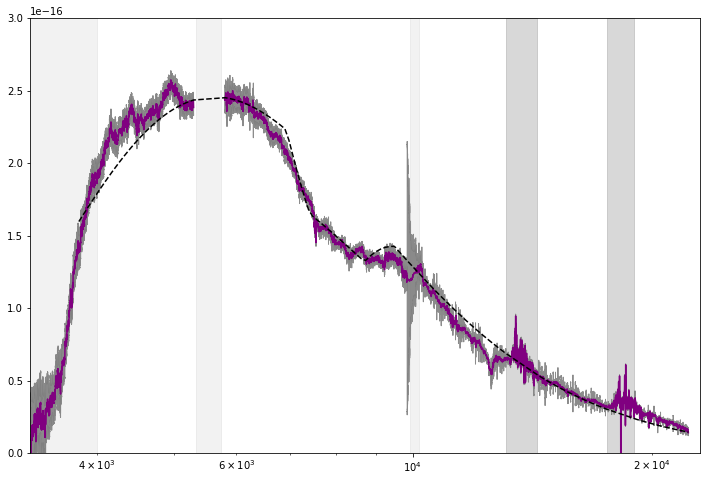

In [62]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(x[:,0], x[:,1], label='X-shooter spectra', color='purple')
#plt.plot(wl, flux, label='X-shooter spectra', color='orange', alpha=0.5)
#p, cov = curve_fit(planck, x[:,0][exc_reg]*10**(-10), x[:,1][exc_reg], sigma = x[:,3][exc_reg],
#                   p0 = [5200, 5*10**(-30)], absolute_sigma=True)
#psig = np.sqrt(np.diagonal(cov)) #*40

#print(p, psig)

plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
plt.fill_between(x[:,0], x[:,1]-x[:,3], x[:,1]+x[:,3], 
                 color='grey', alpha=0.9)
plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14360], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#plt.xlim(9000,12000)
plt.xscale('log') 

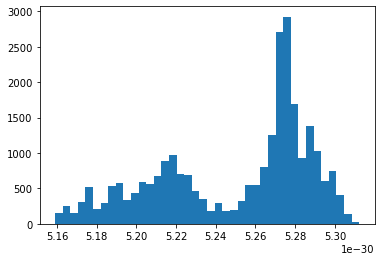

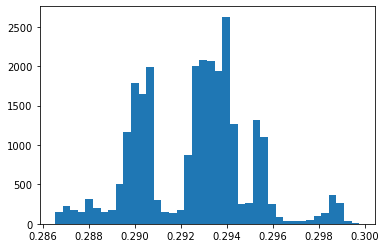

In [68]:
post_N = np.array(res.flatchain["N"])#[-250:]
plt.hist(post_N, bins=40 );

Nlow, N, Nhigh = np.percentile(post_N, 15.9), np.percentile(post_N, 50), np.percentile(post_N, 100-15.9)

plt.figure()
post_Vphot = np.array(res.flatchain["vphot"])#[-250:]
plt.hist(post_Vphot, bins=40 );

vlow, v, vhigh = np.percentile(post_Vphot, 15.9), np.percentile(post_Vphot, 50), np.percentile(post_Vphot, 100-15.9)

In [69]:
n1,_ = lum_dist([0,Nlow], [0,0],
         vlow, 0.1, n_days=1.43)

n2,_ = lum_dist([0,N], [0,0],
         v, 0, n_days=1.43)

n3,_ = lum_dist([0,Nhigh], [0,0],
         vhigh, 0, n_days=1.43)

In [70]:
n2, n2-n1, n3-n2

(42.972996376300244, 0.17373255564311307, 0.16080346464401885)

In [81]:
def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    theta = 2*np.sqrt(N*10**(7)/np.pi)

    v = vphot*c/2 #factor of 2
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23)
    return D_mpc

42.945412061167715 42.59840865634759 43.36801641579023


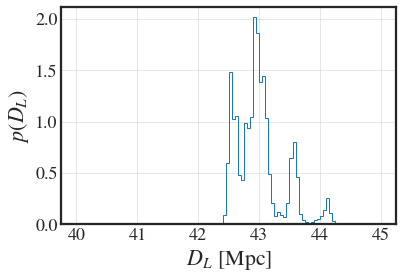

In [82]:
reset_plt(18,22)
dl = lum_dist_arr(res.flatchain['N'], res.flatchain['vphot'])
plt.hist(dl, bins=100, range=(40,45), histtype='step', density=True);
plt.xlabel(r'$D_L$ [Mpc]'), plt.ylabel(r'$p(D_L)$')

print(np.median(dl), np.percentile(dl,15.9), np.percentile(dl,100-15.9))

In [75]:
res.params.valuesdict().values()[:-6]

TypeError: 'dict_values' object is not subscriptable

In [72]:
#pickle_in = open("./data/%s_with_gaussian.pkl"%OB,"rb")
#emcee_res = pickle.load(pickle_in)

IndexError: list index out of range

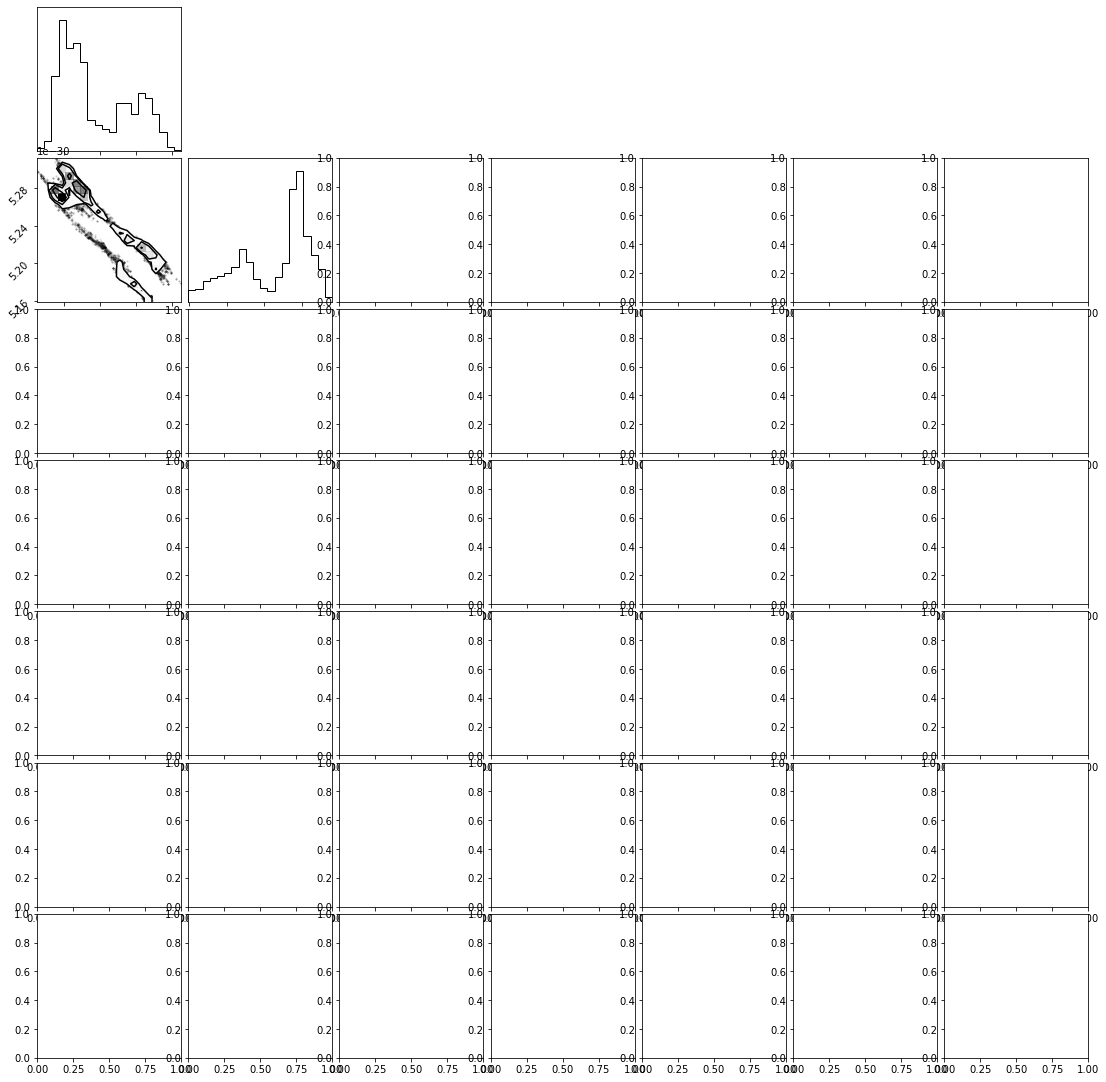

In [76]:
import corner

emcee_corner = corner.corner(res.flatchain, labels=res.var_names,
                             truths=list(res.params.valuesdict().values()))


<Figure size 720x720 with 0 Axes>

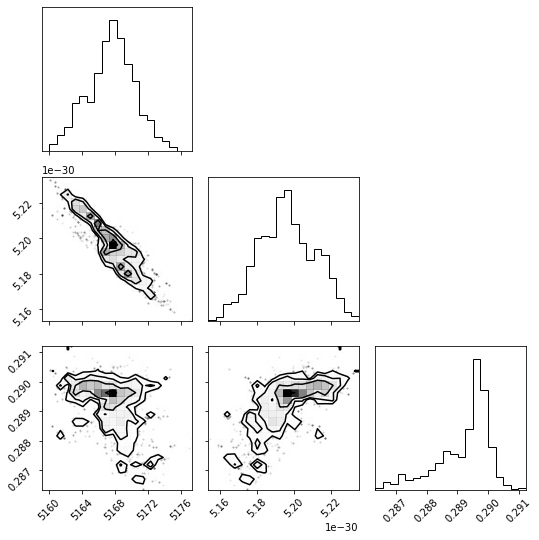

In [77]:
plt.figure(figsize=(10,10))
corner.corner( np.array([emcee_res.flatchain['T'], emcee_res.flatchain['N'], emcee_res.flatchain['vphot']]).T ); 
plt.tight_layout()

In [137]:
list(res.params.valuesdict().values())

[5167.636157356162,
 5.195655321381361e-30,
 0.2895264213482121,
 0.3412291048695331,
 126000,
 4.074997571809552,
 0.0,
 0.3348166988598953,
 0.004115295614483469,
 0.01,
 0.01,
 1.55e-06,
 2.03e-06,
 6e-08,
 6e-08]

In [178]:
def get_data(path, OB, filter_bad = False):

    fac = 10
    # print(int(OB[2:]))
    # if int(OB[2:]) > 5:
    #     fac = 1


    f = fits.open("%s/UVB%s.fits"%(path, OB))
    # print(f[1].columns)
    wl = fac*f[1].data.field("WAVE").flatten()
    q = f[1].data.field("QUAL").flatten()
    mask_wl = (wl > 3200) & (wl < 5600)
    mask_qual = ~q.astype("bool")
    flux = interpolate.interp1d(wl[mask_qual], f[1].data.field("FLUX").flatten()[mask_qual], bounds_error=False, fill_value=0)
    error = interpolate.interp1d(wl[mask_qual], f[1].data.field("ERR").flatten()[mask_qual], bounds_error=False, fill_value=0)
    wl_plot = wl[mask_wl]
    flux = flux(wl_plot)
    error = error(wl_plot)
    wl_UVB = wl_plot
    flux_UVB = flux
    error_UVB = error

    f = fits.open("%s/VIS%s.fits"%(path, OB))
    wl = fac*f[1].data.field("WAVE").flatten()
    q = f[1].data.field("QUAL").flatten()
    try:
        t = f[1].data.field("TRANS").flatten()
    except:
        t = np.ones_like(f[1].data.field("QUAL").flatten())
    mask_wl = (wl > 5600) & (wl < 10200)
    mask_qual = ~q.astype("bool")

    flux = interpolate.interp1d(wl[mask_qual], f[1].data.field("FLUX").flatten()[mask_qual], bounds_error=False, fill_value=0)
    error = interpolate.interp1d(wl[mask_qual], f[1].data.field("ERR").flatten()[mask_qual], bounds_error=False, fill_value=0)
    wl_plot = wl[mask_wl]
    flux = flux(wl_plot)/t[mask_wl]
    error = error(wl_plot)/t[mask_wl]
    wl_VIS = wl_plot
    flux_VIS = flux
    error_VIS = error

    f = fits.open("%s/NIR%s.fits"%(path, OB))
    try:
        f_nod = fits.open("%s/NIR%s_NOD.fits"%(path, OB))
    except:
        f_nod = fits.open("%s/NIR%s.fits"%(path, OB))
    wl = fac*f[1].data.field("WAVE").flatten()
    f[1].data["FLUX"] = np.concatenate((f[1].data["FLUX"].flatten()[(wl <= 22500)], f_nod[1].data["FLUX"].flatten()[(wl > 22500)]))
    f[1].data["ERR"] = np.concatenate((f[1].data["ERR"].flatten()[(wl <= 22500)], f_nod[1].data["ERR"].flatten()[(wl > 22500)]))

    q = f[1].data.field("QUAL").flatten()
    try:
        t = f[1].data.field("TRANS").flatten()
    except:
        t = np.ones_like(f[1].data.field("QUAL").flatten())
    mask_wl = (wl > 10200)
    mask_qual = ~q.astype("bool")
    flux = interpolate.interp1d(wl[mask_qual], f[1].data.field("FLUX").flatten()[mask_qual], bounds_error=False, fill_value=0)
    error = interpolate.interp1d(wl[mask_qual], f[1].data.field("ERR").flatten()[mask_qual], bounds_error=False, fill_value=0)
    wl_plot = wl[mask_wl]
    flux = flux(wl_plot)/t[mask_wl]
    error = error(wl_plot)/t[mask_wl]
    wl_NIR = wl_plot
    flux_NIR = flux
    error_NIR = error

    print(min(wl_UVB))


    wl = np.concatenate((wl_UVB, wl_VIS, wl_NIR))
    flux = np.concatenate((flux_UVB, flux_VIS, flux_NIR))
    error = np.concatenate((error_UVB, error_VIS, error_NIR))

    if filter_bad:

        wl, flux, error = filter_bad_values(wl, flux, error)

    return wl, flux, error

from astropy.io import fits
from scipy import interpolate

In [179]:
path = './'
wl, flux, error = get_data(path, OB)
print(min(wl))

3200.079
3200.079


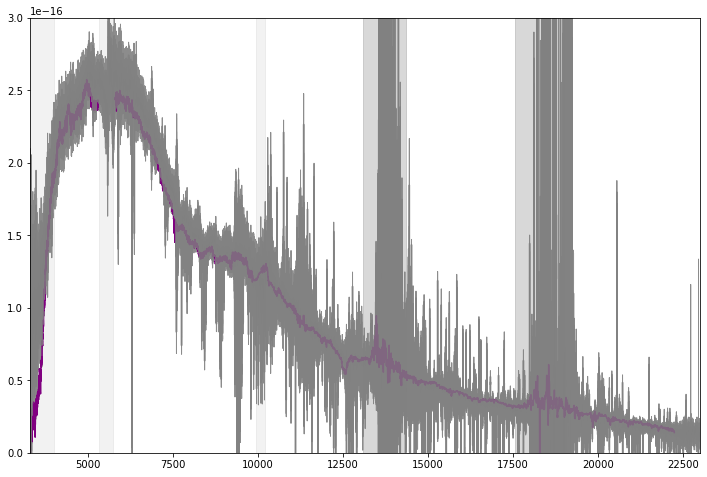

In [62]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(x[:,0], x[:,1], label='X-shooter spectra', color='purple')

plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.8)
#p, cov = curve_fit(planck, x[:,0][exc_reg]*10**(-10), x[:,1][exc_reg], sigma = x[:,3][exc_reg],
#                   p0 = [5200, 5*10**(-30)], absolute_sigma=True)
#psig = np.sqrt(np.diagonal(cov)) #*40

#print(p, psig)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
plt.fill_between(wl, flux-error, flux+error, 
                 color='grey', alpha=0.9)
plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14360], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#plt.xlim(9000,12000)

In [41]:
wl

array([ 4200.061,  4200.261,  4200.461, ..., 22498.75 , 22499.35 ,
       22499.95 ])

(1e-18, 2e-17)

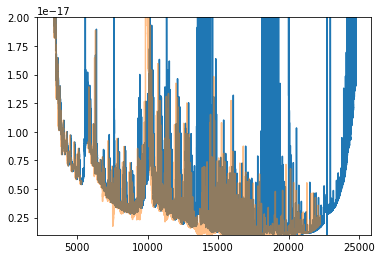

In [79]:
plt.plot(wl, error)
plt.plot(x[:,0], x[:,3], alpha=0.5)

plt.ylim(1e-18,2e-17)